<h1>cnt_access, cnt_result, cnt_printの予測モデルを構築する</h1>

In [1]:
#必要なモジュールのimport
import pandas as pd
import numpy as np
import MeCab
from gensim.models import word2vec
import re
from io import StringIO
from joblib import Parallel, delayed
import pickle

from sklearn import preprocessing as sp
from sklearn.ensemble import RandomForestRegressor

Importエラーが出た場合、適宜モジュールのインストールをお願いします。

In [2]:
#形態要素解析をし、learnW2Vmodelで学習したモデルを使って特徴量を計算するファンクション
def vectorize(docs, model):
    
    try:
        
        mecab = MeCab.Tagger("-Ochasen")
        data = mecab.parse(docs)
        data = StringIO(data.replace("\"", ""))
        data = pd.read_csv(data, sep='\t', header=None)
        data = data.loc[(data[3].str.find("名詞") >= 0) & (data[3].str.find("接頭詞") < 0) & (data[3].str.find("サ変接続") < 0)]
        
        #learnW2Vmodelで学習したボキャブラリーにない単語は無視する
        data = data[data[0].isin(pd.DataFrame.from_dict(model.wv.vocab, orient='index').index)]
        data = data[[0]]
        
        #１プレス発表の特徴量は、すべての単語の特徴量の平均と定義する
        vec = pd.DataFrame(data.applymap(model.wv.word_vec)[0].values.mean(axis=0))
        
        return vec
    
    except:
        
        return []

In [3]:
#vectorizeを使って特徴量の計算結果を返すファンクション
def getPressvec(df, model):

    #データフレームのテキストデータを読み込む
    df['text'] = df['title'] + "\n" + df['summary'] + "\n" + df['content']
    
    #vectorizeを使って特徴量を算出
    pressvec = pd.concat(Parallel(n_jobs=2, verbose=10)([delayed(vectorize)(docs, model) for docs in df['text'].str.lower().values]), axis=1).T
    pressvec.index = df.index

    return pressvec

In [4]:
#学習データとW2Vモデルを読み込み
df = pd.read_csv("data_for_w2v.csv")
model = word2vec.Word2Vec.load("word2vec.gensim.model")

In [5]:
#特徴量計算(時間がかかります)
pressvec = getPressvec(df, model)  

[Parallel(n_jobs=3)]: Batch computation too fast (0.1678s.) Setting batch_size=2.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=3)]: Done   8 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done  18 tasks      | elapsed:    1.8s
[Parallel(n_jobs=3)]: Done  32 tasks      | elapsed:    2.5s
[Parallel(n_jobs=3)]: Done  46 tasks      | elapsed:    3.2s
[Parallel(n_jobs=3)]: Done  64 tasks      | elapsed:    4.1s
[Parallel(n_jobs=3)]: Done  82 tasks      | elapsed:    5.0s
[Parallel(n_jobs=3)]: Done 104 tasks      | elapsed:    6.1s
[Parallel(n_jobs=3)]: Done 126 tasks      | elapsed:    7.2s
[Parallel(n_jobs=3)]: Done 152 tasks      | elapsed:    8.5s
[Parallel(n_jobs=3)]: Done 178 tasks      | elapsed:    9.8s
[Parallel(n_jobs=3)]: Done 208 tasks      | elapsed:   11.3s
[Parallel(n_jobs=3)]: Done 238 tasks      | elapsed:   12.8s
[Parallel(n_jobs=3)]: Done 272 tasks      | elapsed:   14.5s
[Parallel(n_jobs=3)]: Done 306 tasks      | elapsed:   16.2s
[Pa

In [6]:
#データ確認
pressvec.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.129585,-0.202530,-0.090978,-0.134878,0.015656,0.226472,0.362048,-0.015835,0.141697,-0.434220,...,0.257121,-0.384888,0.159366,-0.307208,0.234211,0.068721,-0.100681,0.005776,0.144136,-0.009223
1,0.085557,0.103801,0.293378,0.139763,-0.051168,0.186632,-0.018691,0.177486,0.046464,-0.001685,...,0.451911,-0.292505,0.030816,-0.409733,0.198356,0.049316,0.389080,0.044053,0.110449,0.079995
2,0.012697,0.115791,0.269439,0.380134,0.319218,-0.122642,0.231830,0.037941,0.363622,0.252292,...,0.279668,-0.239055,-0.026405,-0.215481,0.405738,0.007925,0.423629,0.054110,0.295463,-0.051762
3,0.068765,-0.088542,-0.354423,0.224561,-0.069483,0.259749,0.602270,-0.548746,0.790063,-0.935927,...,0.003997,-0.861815,0.240547,-0.389894,0.430159,-0.248120,-0.294356,0.115320,0.304870,-0.285786
4,0.146622,-0.391049,-0.022803,-0.097009,-0.118072,0.198218,0.168975,0.004750,-0.176582,-0.456862,...,0.633758,-0.366188,0.354597,-0.588648,0.271204,0.191824,-0.009261,-0.217041,0.092645,0.006992


In [7]:
#カレンダ情報を説明変数に加える
df['send_date'] = pd.to_datetime(df.send_date)
df['year'] = df.send_date.dt.year
df['month'] = df.send_date.dt.month
df['day'] = df.send_date.dt.day
df['week'] = df.send_date.dt.week
df['weekday'] = df.send_date.dt.weekday

In [8]:
#特徴量のデータフレームに元データの説明変数を加える
pressvec = pd.concat([pressvec, df[['genre_id', 'category_id', 'year', 'month', 'day', 'week', 'weekday']]], axis=1)

In [9]:
#データ確認
pressvec.head()

,0,1,2,3,4,5,6,7,8,9,...,97,98,99,genre_id,category_id,year,month,day,week,weekday
0,0.129585,-0.202530,-0.090978,-0.134878,0.015656,0.226472,0.362048,-0.015835,0.141697,-0.434220,...,0.005776,0.144136,-0.009223,2,2,2016,6,10,23,4
1,0.085557,0.103801,0.293378,0.139763,-0.051168,0.186632,-0.018691,0.177486,0.046464,-0.001685,...,0.044053,0.110449,0.079995,19,99,2016,6,10,23,4
2,0.012697,0.115791,0.269439,0.380134,0.319218,-0.122642,0.231830,0.037941,0.363622,0.252292,...,0.054110,0.295463,-0.051762,21,2,2016,6,10,23,4
3,0.068765,-0.088542,-0.354423,0.224561,-0.069483,0.259749,0.602270,-0.548746,0.790063,-0.935927,...,0.115320,0.304870,-0.285786,23,1,2016,6,10,23,4
4,0.146622,-0.391049,-0.022803,-0.097009,-0.118072,0.198218,0.168975,0.004750,-0.176582,-0.456862,...,-0.217041,0.092645,0.006992,2,6,2016,6,10,23,4


cnt_access RMSE 103.9496890810192
cnt_result RMSE 22.298912552279305
cnt_print RMSE 10.478460211330443


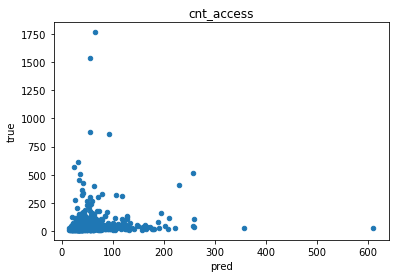

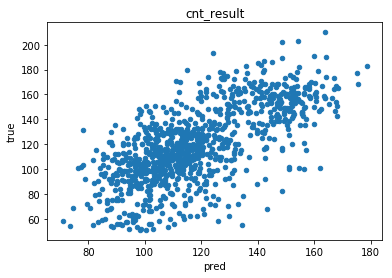

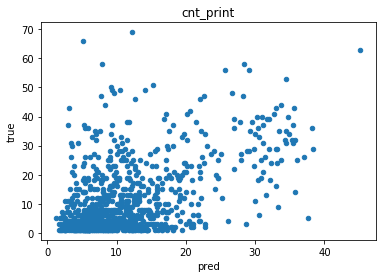

In [11]:
#3つの目的変数の学習モデルを構築する
%matplotlib inline
for i in range(3):

    #8割のデータを使って学習（残り２割のデータはモデルの妥当性検証に使う）
    p = 0.8

    #乱数種の設定
    np.random.seed=0
    
    #目的変数の設定
    target=df.columns[i]

    #学習用データと検証用データのインデックスを選択
    lnindexList = np.random.choice(df.index, size=int(df.index.shape[0]*p), replace=False)
    vdindexList = df.index[df.index.isin(lnindexList)==False].values

    #ランダムフォレストモデルを構築
    rfr = RandomForestRegressor(n_jobs=2,
                                n_estimators=10,
                                )

    rfr.fit(pressvec.ix[df.ix[lnindexList, target].dropna().index].values, df.ix[lnindexList, target].dropna().values)

    #学習モデルを保存
    pickle.dump(rfr, open('pred_' + target + '_model.pkl', 'wb'), protocol=4)
    
    #精度検証
    result = pd.DataFrame(index=vdindexList, columns=['pred'], data=rfr.predict(pressvec.ix[vdindexList]))
    result['true'] = df.ix[vdindexList, target]

    result.plot.scatter(x='pred', y='true', title=target)
    print(target, 'RMSE', ((result['pred'] - result['true'])**2).mean()**0.5)